In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

In [55]:
from tensorflow import keras
from sklearn.metrics import mean_squared_error

## Collect and prepare data for analysis

In [75]:
df = pd.read_csv('INTC.csv',  parse_dates=True)

In [76]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [77]:
df = df[['Close']]  # watch the spaces in the column name 

In [78]:
df

,Close
0,51.529999
1,51.099998
2,51.450001
3,51.380001
4,53.049999
...,...
1253,32.130001
1254,31.889999
1255,32.139999
1256,31.830000


In [79]:
df['Close'].isna().sum()

0

In [80]:
row_count = df.shape[0] # store the number of obersvations (daily temperature readings)
row_count

1258

In [81]:
temps = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
temps.shape

(1258, 1)

In [82]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [83]:
temps = temps[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
temps.shape

(1250, 1)

In [84]:
temps = temps.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
temps

array([[52.310001, 52.279999, 52.779999, ..., 54.669998, 54.900002,
        53.919998],
       [54.639999, 54.810001, 53.5     , ..., 55.439999, 55.32    ,
        55.68    ],
       [55.200001, 57.080002, 56.830002, ..., 54.52    , 54.82    ,
        55.029999],
       ...,
       [25.98    , 26.440001, 27.219999, ..., 29.809999, 29.16    ,
        28.459999],
       [28.129999, 29.030001, 29.360001, ..., 32.669998, 32.889999,
        33.099998],
       [32.830002, 32.810001, 32.52    , ..., 32.139999, 31.83    ,
        31.15    ]])

In [85]:
# we can now see that our days have been organized into rows of sequence length. 

In [86]:
# create our X and y. 
# X will be the 59 days prior...
X = temps[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = temps[:, -1] # all rows, only the last column

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [88]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(87, 9, 1)
(38, 9, 1)


## Simple RNN

In [89]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1
    
model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [90]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
3/3 [==============================] - 3s 225ms/step - loss: 2238.5913 - root_mean_squared_error: 47.3138 - val_loss: 2278.5723 - val_root_mean_squared_error: 47.7344
Epoch 2/600
3/3 [==============================] - 0s 46ms/step - loss: 2214.7324 - root_mean_squared_error: 47.0609 - val_loss: 2255.3926 - val_root_mean_squared_error: 47.4910
Epoch 3/600
3/3 [==============================] - 0s 28ms/step - loss: 2191.9019 - root_mean_squared_error: 46.8178 - val_loss: 2232.8752 - val_root_mean_squared_error: 47.2533
Epoch 4/600
3/3 [==============================] - 0s 31ms/step - loss: 2169.9404 - root_mean_squared_error: 46.5826 - val_loss: 2211.1941 - val_root_mean_squared_error: 47.0233
Epoch 5/600
3/3 [==============================] - 0s 27ms/step - loss: 2148.7292 - root_mean_squared_error: 46.3544 - val_loss: 2189.8000 - val_root_mean_squared_error: 46.7953
Epoch 6/600
3/3 [==============================] - 0s 32ms/step - loss: 2127.5427 - root_mean_squared_error: 

Epoch 47/600
3/3 [==============================] - 0s 36ms/step - loss: 1254.2927 - root_mean_squared_error: 35.4160 - val_loss: 1284.1877 - val_root_mean_squared_error: 35.8356
Epoch 48/600
3/3 [==============================] - 0s 33ms/step - loss: 1242.6583 - root_mean_squared_error: 35.2514 - val_loss: 1272.1931 - val_root_mean_squared_error: 35.6678
Epoch 49/600
3/3 [==============================] - 0s 36ms/step - loss: 1230.9955 - root_mean_squared_error: 35.0855 - val_loss: 1260.2992 - val_root_mean_squared_error: 35.5007
Epoch 50/600
3/3 [==============================] - 0s 28ms/step - loss: 1219.3408 - root_mean_squared_error: 34.9191 - val_loss: 1248.5298 - val_root_mean_squared_error: 35.3345
Epoch 51/600
3/3 [==============================] - 0s 37ms/step - loss: 1207.9495 - root_mean_squared_error: 34.7556 - val_loss: 1236.8441 - val_root_mean_squared_error: 35.1688
Epoch 52/600
3/3 [==============================] - 0s 29ms/step - loss: 1196.7126 - root_mean_squared_er

Epoch 93/600
3/3 [==============================] - 0s 31ms/step - loss: 800.8484 - root_mean_squared_error: 28.2993 - val_loss: 821.4168 - val_root_mean_squared_error: 28.6604
Epoch 94/600
3/3 [==============================] - 0s 35ms/step - loss: 792.8904 - root_mean_squared_error: 28.1583 - val_loss: 813.1896 - val_root_mean_squared_error: 28.5165
Epoch 95/600
3/3 [==============================] - 0s 24ms/step - loss: 784.9062 - root_mean_squared_error: 28.0162 - val_loss: 805.0482 - val_root_mean_squared_error: 28.3734
Epoch 96/600
3/3 [==============================] - 0s 28ms/step - loss: 777.0710 - root_mean_squared_error: 27.8760 - val_loss: 796.9719 - val_root_mean_squared_error: 28.2307
Epoch 97/600
3/3 [==============================] - 0s 32ms/step - loss: 768.9922 - root_mean_squared_error: 27.7307 - val_loss: 789.0115 - val_root_mean_squared_error: 28.0893
Epoch 98/600
3/3 [==============================] - 0s 24ms/step - loss: 761.7226 - root_mean_squared_error: 27.599

3/3 [==============================] - 0s 32ms/step - loss: 500.7079 - root_mean_squared_error: 22.3765 - val_loss: 512.9882 - val_root_mean_squared_error: 22.6492
Epoch 140/600
3/3 [==============================] - 0s 28ms/step - loss: 495.6548 - root_mean_squared_error: 22.2633 - val_loss: 507.6615 - val_root_mean_squared_error: 22.5313
Epoch 141/600
3/3 [==============================] - 0s 24ms/step - loss: 490.5321 - root_mean_squared_error: 22.1480 - val_loss: 502.4060 - val_root_mean_squared_error: 22.4144
Epoch 142/600
3/3 [==============================] - 0s 22ms/step - loss: 485.4864 - root_mean_squared_error: 22.0338 - val_loss: 497.2213 - val_root_mean_squared_error: 22.2985
Epoch 143/600
3/3 [==============================] - 0s 30ms/step - loss: 480.6003 - root_mean_squared_error: 21.9226 - val_loss: 492.0886 - val_root_mean_squared_error: 22.1831
Epoch 144/600
3/3 [==============================] - 0s 30ms/step - loss: 475.5910 - root_mean_squared_error: 21.8080 - val_

3/3 [==============================] - 0s 24ms/step - loss: 185.0359 - root_mean_squared_error: 13.6028 - val_loss: 188.8672 - val_root_mean_squared_error: 13.7429
Epoch 232/600
3/3 [==============================] - 0s 24ms/step - loss: 183.0551 - root_mean_squared_error: 13.5298 - val_loss: 186.7099 - val_root_mean_squared_error: 13.6642
Epoch 233/600
3/3 [==============================] - 0s 24ms/step - loss: 180.8775 - root_mean_squared_error: 13.4491 - val_loss: 184.5687 - val_root_mean_squared_error: 13.5856
Epoch 234/600
3/3 [==============================] - 0s 32ms/step - loss: 178.8528 - root_mean_squared_error: 13.3736 - val_loss: 182.4728 - val_root_mean_squared_error: 13.5082
Epoch 235/600
3/3 [==============================] - 0s 31ms/step - loss: 176.8231 - root_mean_squared_error: 13.2975 - val_loss: 180.4178 - val_root_mean_squared_error: 13.4320
Epoch 236/600
3/3 [==============================] - 0s 29ms/step - loss: 174.8347 - root_mean_squared_error: 13.2225 - val_

Epoch 324/600
3/3 [==============================] - 0s 33ms/step - loss: 65.1269 - root_mean_squared_error: 8.0701 - val_loss: 67.5805 - val_root_mean_squared_error: 8.2207
Epoch 325/600
3/3 [==============================] - 0s 26ms/step - loss: 64.4587 - root_mean_squared_error: 8.0286 - val_loss: 66.9419 - val_root_mean_squared_error: 8.1818
Epoch 326/600
3/3 [==============================] - 0s 28ms/step - loss: 63.8145 - root_mean_squared_error: 7.9884 - val_loss: 66.2856 - val_root_mean_squared_error: 8.1416
Epoch 327/600
3/3 [==============================] - 0s 27ms/step - loss: 63.1506 - root_mean_squared_error: 7.9467 - val_loss: 65.6139 - val_root_mean_squared_error: 8.1002
Epoch 328/600
3/3 [==============================] - 0s 24ms/step - loss: 62.4982 - root_mean_squared_error: 7.9056 - val_loss: 65.0315 - val_root_mean_squared_error: 8.0642
Epoch 329/600
3/3 [==============================] - 0s 24ms/step - loss: 61.9064 - root_mean_squared_error: 7.8681 - val_loss: 64

3/3 [==============================] - 0s 28ms/step - loss: 27.7884 - root_mean_squared_error: 5.2715 - val_loss: 30.2738 - val_root_mean_squared_error: 5.5022
Epoch 419/600
3/3 [==============================] - 0s 29ms/step - loss: 27.5563 - root_mean_squared_error: 5.2494 - val_loss: 30.0807 - val_root_mean_squared_error: 5.4846
Epoch 420/600
3/3 [==============================] - 0s 23ms/step - loss: 27.3158 - root_mean_squared_error: 5.2265 - val_loss: 29.8820 - val_root_mean_squared_error: 5.4664
Epoch 421/600
3/3 [==============================] - 0s 24ms/step - loss: 27.0993 - root_mean_squared_error: 5.2057 - val_loss: 29.5962 - val_root_mean_squared_error: 5.4402
Epoch 422/600
3/3 [==============================] - 0s 22ms/step - loss: 26.8618 - root_mean_squared_error: 5.1828 - val_loss: 29.3447 - val_root_mean_squared_error: 5.4171
Epoch 423/600
3/3 [==============================] - 0s 32ms/step - loss: 26.6847 - root_mean_squared_error: 5.1657 - val_loss: 29.1403 - val_ro

3/3 [==============================] - 0s 25ms/step - loss: 13.7357 - root_mean_squared_error: 3.7062 - val_loss: 16.8870 - val_root_mean_squared_error: 4.1094
Epoch 513/600
3/3 [==============================] - 0s 31ms/step - loss: 13.6391 - root_mean_squared_error: 3.6931 - val_loss: 16.8277 - val_root_mean_squared_error: 4.1022
Epoch 514/600
3/3 [==============================] - 0s 39ms/step - loss: 13.5436 - root_mean_squared_error: 3.6802 - val_loss: 16.7634 - val_root_mean_squared_error: 4.0943
Epoch 515/600
3/3 [==============================] - 0s 22ms/step - loss: 13.4323 - root_mean_squared_error: 3.6650 - val_loss: 16.6451 - val_root_mean_squared_error: 4.0798
Epoch 516/600
3/3 [==============================] - 0s 26ms/step - loss: 13.3572 - root_mean_squared_error: 3.6547 - val_loss: 16.5729 - val_root_mean_squared_error: 4.0710
Epoch 517/600
3/3 [==============================] - 0s 23ms/step - loss: 13.2946 - root_mean_squared_error: 3.6462 - val_loss: 16.4609 - val_ro

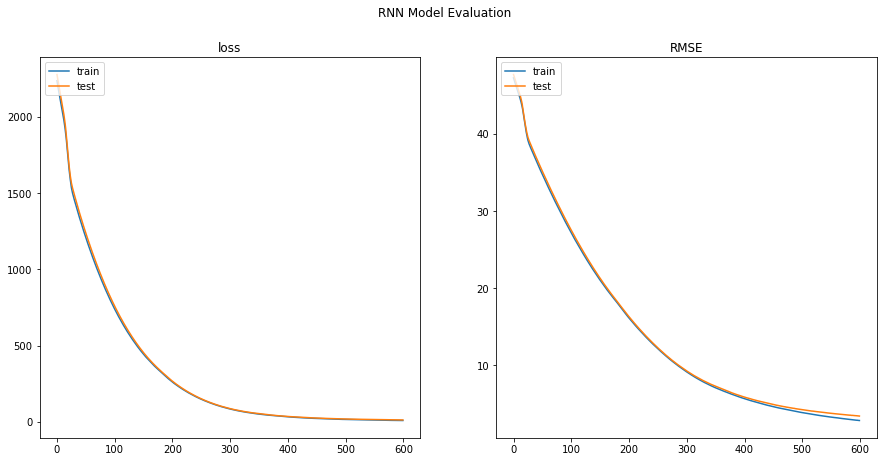

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [93]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


2/2 [==============================] - 0s 16ms/step


3.4038365132920774

# A normal (cross-sectional) NN

In [94]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 4ms/step - loss: 14.2405
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 6.6428
Epoch 3/100
3/3 [==============================] - 0s 0s/step - loss: 8.2021
Epoch 4/100
3/3 [==============================] - 0s 0s/step - loss: 3.1785
Epoch 5/100
3/3 [==============================] - 0s 0s/step - loss: 4.8409
Epoch 6/100
3/3 [==============================] - 0s 0s/step - loss: 4.4739
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 3.1814
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 3.5436
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 3.2018
Epoch 10/100
3/3 [==============================] - 0s 7ms/step - loss: 2.8491
Epoch 11/100
3/3 [==============================] - 0s 0s/step - loss: 3.0475
Epoch 12/100
3/3 [==============================] - 0s 4ms/step - loss: 2.8165
Epoch 13/100
3/3 [==============================] - 0s 0s/step - 

### Predictions

In [95]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


In [96]:
mean_squared_error(y_test, y_pred)

2.5892813150083818

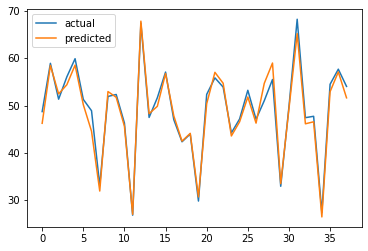

In [97]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [98]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 2s 16ms/step - loss: 1366.3193
Epoch 2/30
3/3 [==============================] - 0s 567us/step - loss: 933.3687
Epoch 3/30
3/3 [==============================] - 0s 8ms/step - loss: 642.9321
Epoch 4/30
3/3 [==============================] - 0s 8ms/step - loss: 473.1391
Epoch 5/30
3/3 [==============================] - 0s 7ms/step - loss: 341.8545
Epoch 6/30
3/3 [==============================] - 0s 6ms/step - loss: 234.4016
Epoch 7/30
3/3 [==============================] - 0s 8ms/step - loss: 149.6209
Epoch 8/30
3/3 [==============================] - 0s 9ms/step - loss: 84.3336
Epoch 9/30
3/3 [==============================] - 0s 8ms/step - loss: 37.4116
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 17.1370
Epoch 11/30
3/3 [==============================] - 0s 7ms/step - loss: 32.1438
Epoch 12/30
3/3 [==============================] - 0s 11ms/step - loss: 28.6407
Epoch 13/30
3/3 [==============================] 

### Predictions

In [102]:
#Predict:
y_pred = model.predict(X_test)


2/2 [==============================] - 0s 0s/step


In [103]:
mean_squared_error(y_test, y_pred)

4.383485412163167

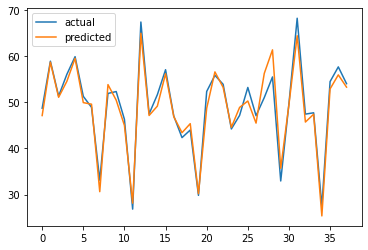

In [104]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [105]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [106]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 6s 16ms/step - loss: 2479.9229
Epoch 2/30
3/3 [==============================] - 0s 8ms/step - loss: 2444.9641
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 2411.3818
Epoch 4/30
3/3 [==============================] - 0s 16ms/step - loss: 2379.2666
Epoch 5/30
3/3 [==============================] - 0s 16ms/step - loss: 2347.0789
Epoch 6/30
3/3 [==============================] - 0s 16ms/step - loss: 2314.0757
Epoch 7/30
3/3 [==============================] - 0s 18ms/step - loss: 2280.7285
Epoch 8/30
3/3 [==============================] - 0s 11ms/step - loss: 2246.7822
Epoch 9/30
3/3 [==============================] - 0s 11ms/step - loss: 2213.2646
Epoch 10/30
3/3 [==============================] - 0s 11ms/step - loss: 2179.1130
Epoch 11/30
3/3 [==============================] - 0s 11ms/step - loss: 2144.3411
Epoch 12/30
3/3 [==============================] - 0s 10ms/step - loss: 2108.9019
Epoch 13/30
3/3 [=========

### Predictions

In [107]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 7ms/step


In [108]:
mean_squared_error(y_test, y_pred)

1712.4353517988334

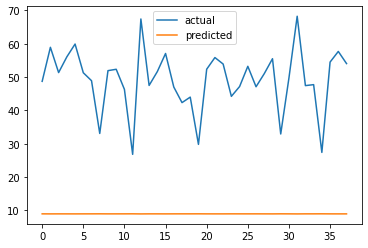

In [109]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [110]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [111]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 4s 24ms/step - loss: 2306.2993
Epoch 2/30
3/3 [==============================] - 0s 16ms/step - loss: 2103.1257
Epoch 3/30
3/3 [==============================] - 0s 12ms/step - loss: 1863.7705
Epoch 4/30
3/3 [==============================] - 0s 19ms/step - loss: 1633.8578
Epoch 5/30
3/3 [==============================] - 0s 12ms/step - loss: 1388.4614
Epoch 6/30
3/3 [==============================] - 0s 11ms/step - loss: 1040.7122
Epoch 7/30
3/3 [==============================] - 0s 11ms/step - loss: 619.8370
Epoch 8/30
3/3 [==============================] - 0s 9ms/step - loss: 158.1030
Epoch 9/30
3/3 [==============================] - 0s 11ms/step - loss: 3.5430
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 3.2633
Epoch 11/30
3/3 [==============================] - 0s 12ms/step - loss: 2.7071
Epoch 12/30
3/3 [==============================] - 0s 10ms/step - loss: 2.7126
Epoch 13/30
3/3 [========================

### Predictions

In [112]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [113]:
mean_squared_error(y_test, y_pred)

2.0965374328401665

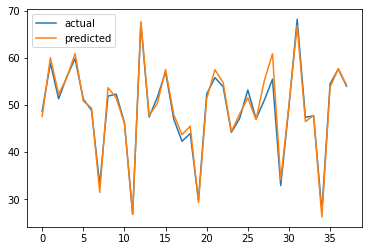

In [114]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [115]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [116]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 5s 23ms/step - loss: 2419.8865
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 2008.3926
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 1508.3656
Epoch 4/30
3/3 [==============================] - 0s 12ms/step - loss: 1119.0895
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 747.5531
Epoch 6/30
3/3 [==============================] - 0s 12ms/step - loss: 432.6419
Epoch 7/30
3/3 [==============================] - 0s 11ms/step - loss: 155.9689
Epoch 8/30
3/3 [==============================] - 0s 12ms/step - loss: 18.9165
Epoch 9/30
3/3 [==============================] - 0s 11ms/step - loss: 16.3771
Epoch 10/30
3/3 [==============================] - 0s 9ms/step - loss: 14.3608
Epoch 11/30
3/3 [==============================] - 0s 8ms/step - loss: 10.0015
Epoch 12/30
3/3 [==============================] - 0s 8ms/step - loss: 9.0682
Epoch 13/30
3/3 [==========================

### Predictions

In [117]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 15ms/step


In [119]:
mean_squared_error(y_test, y_pred)

1.7312110912839032

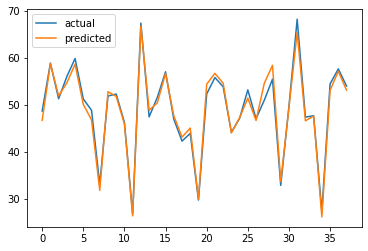

In [120]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

In [129]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [131]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 3s 23ms/step - loss: 2927.2734
Epoch 2/30
3/3 [==============================] - 0s 12ms/step - loss: 2449.9609
Epoch 3/30
3/3 [==============================] - 0s 8ms/step - loss: 1998.5599
Epoch 4/30
3/3 [==============================] - 0s 13ms/step - loss: 1575.6962
Epoch 5/30
3/3 [==============================] - 0s 7ms/step - loss: 1233.1189
Epoch 6/30
3/3 [==============================] - 0s 8ms/step - loss: 893.2599
Epoch 7/30
3/3 [==============================] - 0s 11ms/step - loss: 547.7496
Epoch 8/30
3/3 [==============================] - 0s 9ms/step - loss: 241.4074
Epoch 9/30
3/3 [==============================] - 0s 16ms/step - loss: 45.1139
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 25.5550
Epoch 11/30
3/3 [==============================] - 0s 9ms/step - loss: 106.9449
Epoch 12/30
3/3 [==============================] - 0s 12ms/step - loss: 92.7349
Epoch 13/30
3/3 [========================

In [ ]:
### Predictions

In [132]:
#Predict:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


In [133]:
mean_squared_error(y_test, y_pred)

2.3347495603269146

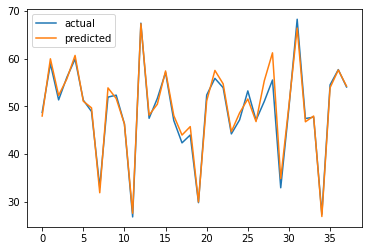

In [134]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

#Conv1D model performs the best with a mean squared error of 1.7312110912839032, followed closely by the normal (cross-sectional) NN with a mean squared error of 2.5892813150083818 and the GRU model with a mean squared error of 2.0965374328401665.

#The Simple RNN model has a higher mean squared error than the other models, indicating that it is not performing as well as the others. Additionally, the LSTM with one layer and more layers have higher mean squared error values compared to the other models. This could be due to overfitting or underfitting issues.

#Overall, the Conv1D model seems to be the best performing model among the ones tested